In [1]:
trip_data = [
    (1, "2024-12-18 10:00:00", "2024-12-18 10:30:00", 15.0, 30.0),
    (2, "2024-12-18 11:00:00", "2024-12-18 11:20:00", 10.0, 20.0),
    (3, "2024-12-18 12:00:00", "2024-12-18 12:45:00", 20.0, 40.0),
    (4, "2024-12-18 13:30:00", "2024-12-18 14:15:00", 25.0, 50.0),
    (5, "2024-12-18 14:00:00", "2024-12-18 14:40:00", 18.0, 36.0),
]

columns = ["TripID", "StartTime", "EndTime", "Distance", "Fare"]

import pandas as pd

trip_df = pd.DataFrame(trip_data, columns=columns)
trip_df.to_csv("trip_data.csv", index=False)


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Trip Data Analysis").getOrCreate()

trip_df = spark.read.csv("trip_data.csv", header=True, inferSchema=True)
trip_df.show()

+------+-------------------+-------------------+--------+----+
|TripID|          StartTime|            EndTime|Distance|Fare|
+------+-------------------+-------------------+--------+----+
|     1|2024-12-18 10:00:00|2024-12-18 10:30:00|    15.0|30.0|
|     2|2024-12-18 11:00:00|2024-12-18 11:20:00|    10.0|20.0|
|     3|2024-12-18 12:00:00|2024-12-18 12:45:00|    20.0|40.0|
|     4|2024-12-18 13:30:00|2024-12-18 14:15:00|    25.0|50.0|
|     5|2024-12-18 14:00:00|2024-12-18 14:40:00|    18.0|36.0|
+------+-------------------+-------------------+--------+----+



In [3]:
from pyspark.sql.functions import unix_timestamp, col

trip_df = trip_df.withColumn(
    "TripDuration",
    (unix_timestamp("EndTime") - unix_timestamp("StartTime")) / 60
)
trip_df.select("TripID", "TripDuration").show()

+------+------------+
|TripID|TripDuration|
+------+------------+
|     1|        30.0|
|     2|        20.0|
|     3|        45.0|
|     4|        45.0|
|     5|        40.0|
+------+------------+



In [4]:
average_fare_per_mile = trip_df.withColumn("FarePerMile", col("Fare") / col("Distance")) \
                               .select("FarePerMile").agg({"FarePerMile": "avg"}).first()[0]

print(f"Average Fare per Mile: {average_fare_per_mile:.2f}")

Average Fare per Mile: 2.00


In [5]:
top_longest_trips = trip_df.orderBy(col("Distance").desc()).limit(3)
top_longest_trips.show()

+------+-------------------+-------------------+--------+----+------------+
|TripID|          StartTime|            EndTime|Distance|Fare|TripDuration|
+------+-------------------+-------------------+--------+----+------------+
|     4|2024-12-18 13:30:00|2024-12-18 14:15:00|    25.0|50.0|        45.0|
|     3|2024-12-18 12:00:00|2024-12-18 12:45:00|    20.0|40.0|        45.0|
|     5|2024-12-18 14:00:00|2024-12-18 14:40:00|    18.0|36.0|        40.0|
+------+-------------------+-------------------+--------+----+------------+



In [6]:
from pyspark.sql.functions import hour

trip_hourly = trip_df.withColumn("Hour", hour("StartTime")) \
                     .groupBy("Hour").count()

trip_hourly.show()

+----+-----+
|Hour|count|
+----+-----+
|  12|    1|
|  13|    1|
|  10|    1|
|  11|    1|
|  14|    1|
+----+-----+



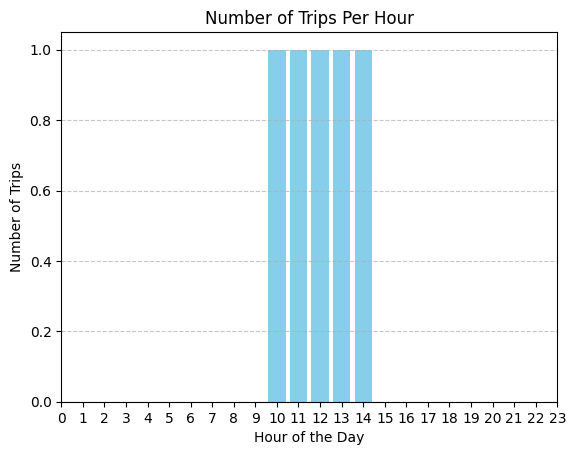

In [7]:
import matplotlib.pyplot as plt

hourly_data = trip_hourly.collect()
hours = [row['Hour'] for row in hourly_data]
trip_counts = [row['count'] for row in hourly_data]

plt.bar(hours, trip_counts, color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips Per Hour')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()